This file contains python code to compare with sinica paper

It is under the linear setting

Now, I use the same X and beta from the paper (on Sep 4, 2023)

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn, gen_sini_Xthetas
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from hdf_utils.utils import gen_lam_seq
from hdf_utils.hypo_test import obt_test_stat
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl, get_local_min_idxs
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization
from penalties.scad_pen import SCAD
from models.linear_model import LinearModel

from joblib import Parallel, delayed

In [5]:
import logging

logger = logging.getLogger("tmp")
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler() # for console. 
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)

logger.addHandler(ch)

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Params

In [7]:
paras = edict()
paras.save_dir = RES_ROOT/"simu_linear_sinica_samebetaX_test3_rtol"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

## Fns

In [8]:
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]
_err_fn = lambda x: np.nanmean(x**2)

<function __main__.<lambda>(x)>

# Analysis

In [9]:
can_Ns = [4, 6, 8, 10, 12, 14, 16]
can_lams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1, 2, 8];
c1 = 0.0

0.0

## Step 1

In [10]:
opt_lamNs = []
for cur_seed in trange(100):
    errs_N = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            f2_fil = list(paras.save_dir.glob(f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_cv.pkl"))[0]
            t_res2 = load_pkl(f2_fil, verbose=0)
            errs.append(_err_fn(t_res2.cv_errs))
        min_idx = _get_min_idx(errs);
        errs_N.append((cur_seed, cur_N, can_lams[min_idx], errs[min_idx]))
        errs_N_sorted = sorted(errs_N, key=lambda x:x[-1]);
    opt_lamNs.append(errs_N_sorted[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.27it/s]


In [11]:
# save it
save_pkl(paras.save_dir/f"opt_lamNs_100_c1_{c1*1000:.0f}.pkl", opt_lamNs, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_samebetaX_test3_rtol/opt_lamNs_100_c1_0.pkl


## Step 2

In [12]:
opt_lamNs =  load_pkl(paras.save_dir/f"opt_lamNs_100_c1_{c1*1000:.0f}.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_samebetaX_test3_rtol/opt_lamNs_100_c1_0.pkl


In [14]:
def _test_fn(Cmat, res1,  rtols=[0, 0], is_verbose=False):
    torch.set_default_tensor_type(torch.DoubleTensor)
    _paras = res1._paras
    
    est_Gam_full = torch.zeros_like(torch.tensor(_paras.Gam_GT_est)).to(torch.get_default_dtype());
    opt = res1.main_res[0]
        
    est_Gam = opt.Gamk
    est_alp = opt.alpk
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    est_Gam_full[:, _paras.keep_idxs] = est_Gam.clone()
    _paras.svdinv_eps_Q = rtols[0]
    _paras.svdinv_eps_Psi = rtols[1]
    T_v = obt_test_stat(res1.model, est_alp, est_Gam, Cmat, _paras).item() 
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    
    res3 = edict()
    res3.T_v = T_v
    res3.pval = pval
    res3.Cmat = Cmat
    #if is_save:
    #    save_pkl(_paras.save_dir/f3_name, res3, verbose=is_verbose)
    return res3.T_v, res3.pval

In [15]:
Cmat = np.eye(3)
all_coms = list(itertools.product([1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 0], [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 0]))
ress = []
for cur_seed, cur_N, cur_lam, _ in tqdm(opt_lamNs):
    f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_est.pkl"
    res1 = load_pkl(paras.save_dir/f1_name, verbose=False);
    res = []
    with Parallel(n_jobs=20) as parallel:
        res = parallel(delayed(_test_fn)(Cmat=Cmat, res1=res1, rtols=rtols) for rtols
                        in all_coms)

    ress.append(res)
ress = np.array(ress);
if not (paras.save_dir/f"opt_lamNs_100_c1_{c1*1000:.0f}_ress.pkl").exists():
    save_pkl(paras.save_dir/f"opt_lamNs_100_c1_{c1*1000:.0f}_ress.pkl", ress)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_samebetaX_test3_rtol/opt_lamNs_100_c1_0_ress.pkl


### find the good rtol

In [22]:
ress0 = load_pkl(paras.save_dir/f"opt_lamNs_100_c1_0_ress.pkl");
ress1 = load_pkl(paras.save_dir/f"opt_lamNs_100_c1_100_ress.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_samebetaX_test3_rtol/opt_lamNs_100_c1_0_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_samebetaX_test3_rtol/opt_lamNs_100_c1_100_ress.pkl


In [23]:
ress0_T = ress0[:,:, 0]
ress0_Pval = ress0[:,:, -1];
ress1_T = ress1[:,:, 0]
ress1_Pval = ress1[:,:, -1];
cans = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 0];

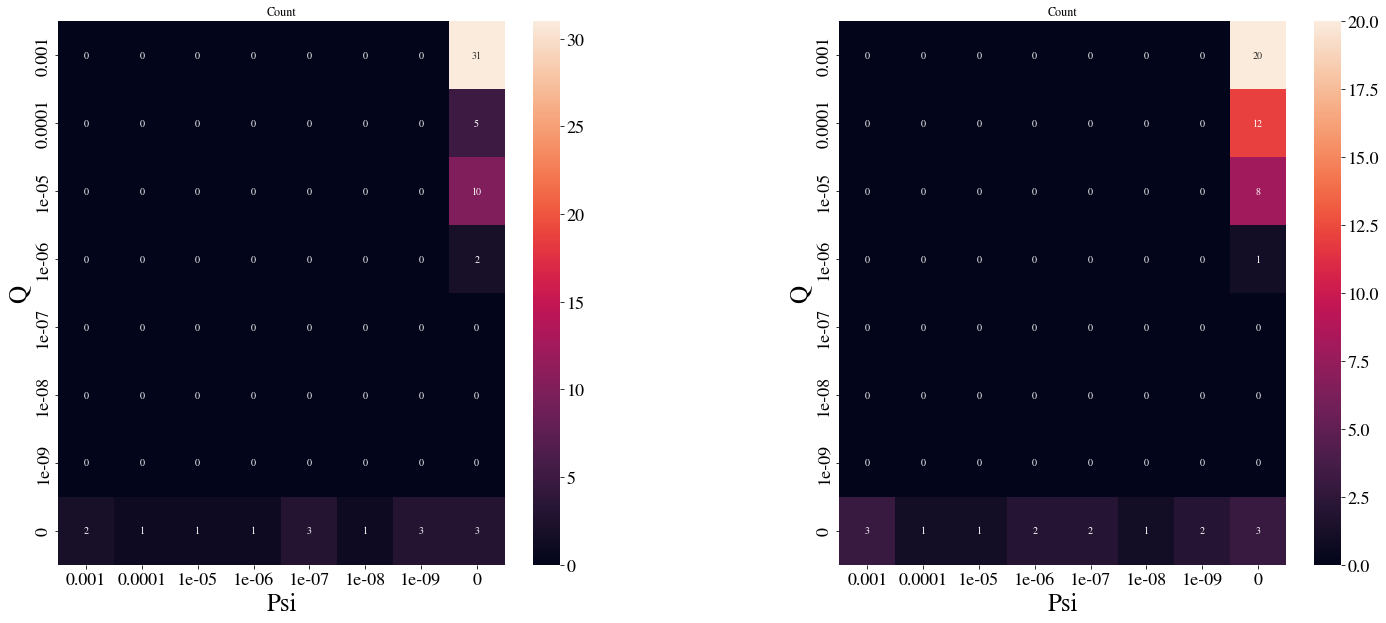

In [37]:
# <0 ct
vec0ct = np.sum(ress0_T< 0, axis=0);
vec1ct = np.sum(ress1_T< 0, axis=0);

mat0 = vec0ct.reshape(8, 8)
mat1 = vec1ct.reshape(8, 8)

plt.figure(figsize=[24, 10])
plt.subplot(121)
plt.title("Count")
sns.heatmap(mat0, annot=True, fmt=".0f")
plt.ylabel("Q")
plt.yticks(np.arange(8)+0.5, cans);
plt.xlabel("Psi")
plt.xticks(np.arange(8)+0.5, cans);

plt.subplot(122)
plt.title("Count")
sns.heatmap(mat1, annot=True, fmt=".0f")
plt.ylabel("Q")
plt.yticks(np.arange(8)+0.5, cans);
plt.xlabel("Psi")
plt.xticks(np.arange(8)+0.5, cans);

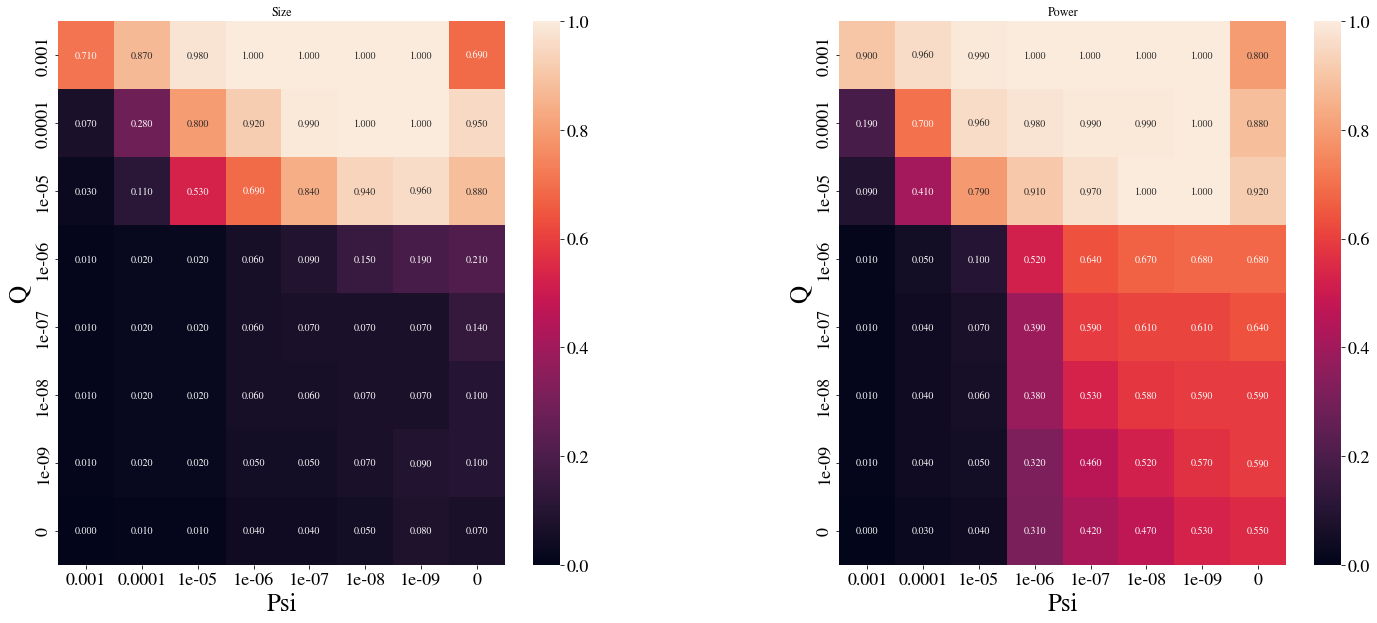

In [55]:
# power size
vec0test = np.mean(ress0_Pval < 0.05, axis=0);
vec1test = np.mean(ress1_Pval < 0.05, axis=0);

mat0 = vec0test.reshape(8, 8)
mat1 = vec1test.reshape(8, 8)

plt.figure(figsize=[24, 10])
plt.subplot(121)
plt.title("Size")
sns.heatmap(mat0, annot=True, fmt=".3f")
plt.ylabel("Q")
plt.yticks(np.arange(8)+0.5, cans);
plt.xlabel("Psi")
plt.xticks(np.arange(8)+0.5, cans);

plt.subplot(122)
plt.title("Power")
sns.heatmap(mat1, annot=True, fmt=".3f")
plt.ylabel("Q")
plt.yticks(np.arange(8)+0.5, cans);
plt.xlabel("Psi")
plt.xticks(np.arange(8)+0.5, cans);

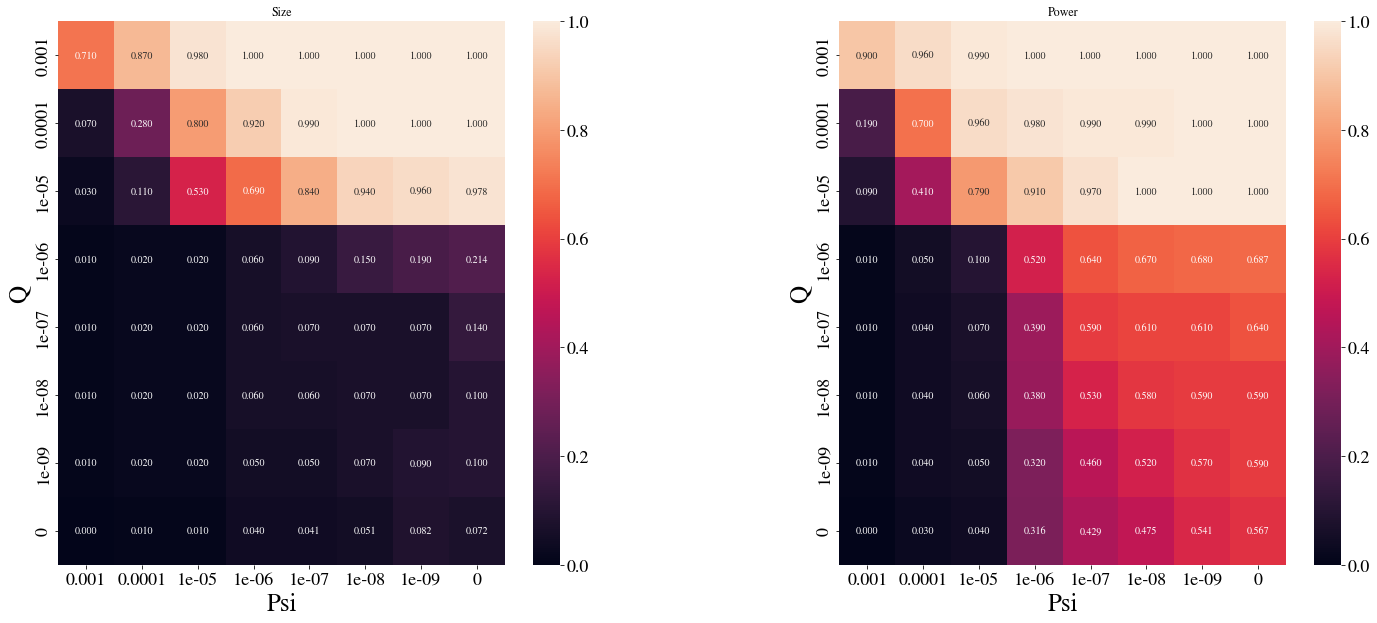

In [56]:
vec0testadj = []
for res_Pval, res_T in zip(ress0_Pval.T, ress0_T.T):
    vec0testadj.append(np.mean(res_Pval[res_T>=0]<0.05))
vec0testadj = np.array(vec0testadj);

vec1testadj = []
for res_Pval, res_T in zip(ress1_Pval.T, ress1_T.T):
    vec1testadj.append(np.mean(res_Pval[res_T>=0]<0.05))
vec1testadj = np.array(vec1testadj);

mat0 = vec0testadj.reshape(8, 8)
mat1 = vec1testadj.reshape(8, 8)

plt.figure(figsize=[24, 10])
plt.subplot(121)
plt.title("Size")
sns.heatmap(mat0, annot=True, fmt=".3f")
plt.ylabel("Q")
plt.yticks(np.arange(8)+0.5, cans);
plt.xlabel("Psi")
plt.xticks(np.arange(8)+0.5, cans);

plt.subplot(122)
plt.title("Power")
sns.heatmap(mat1, annot=True, fmt=".3f")
plt.ylabel("Q")
plt.yticks(np.arange(8)+0.5, cans);
plt.xlabel("Psi")
plt.xticks(np.arange(8)+0.5, cans);

In [76]:
import pandas as pd
all_coms = np.array(list(itertools.product([1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 0], [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 0])));
kpidx = np.bitwise_and(vec0test>=0.04, vec0test<=0.07)
kpidx_adj = np.bitwise_and(vec0testadj>=0.04, vec0testadj<=0.07)
kpidx_b = np.bitwise_or(kpidx, kpidx_adj)
df = np.hstack([vec0test[kpidx_b][:, np.newaxis], 
                vec0testadj[kpidx_b][:, np.newaxis], 
                vec1test[kpidx_b][:, np.newaxis], 
                vec1testadj[kpidx_b][:, np.newaxis],
                all_coms[kpidx_b]]);
df = pd.DataFrame(df)
df.columns = ["Size1", "Size2", "Power1", "Power2", "Q", "Psi"]
df

,Size1,Size2,Power1,Power2,Q,Psi
0,0.07,0.070000,0.19,0.190000,1.000000e-04,1.000000e-03
1,0.06,0.060000,0.52,0.520000,1.000000e-06,1.000000e-06
2,0.06,0.060000,0.39,0.390000,1.000000e-07,1.000000e-06
3,0.07,0.070000,0.59,0.590000,1.000000e-07,1.000000e-07
4,0.07,0.070000,0.61,0.610000,1.000000e-07,1.000000e-08
5,0.07,0.070000,0.61,0.610000,1.000000e-07,1.000000e-09
6,0.06,0.060000,0.38,0.380000,1.000000e-08,1.000000e-06
7,0.06,0.060000,0.53,0.530000,1.000000e-08,1.000000e-07
8,0.07,0.070000,0.58,0.580000,1.000000e-08,1.000000e-08
9,0.07,0.070000,0.59,0.590000,1.000000e-08,1.000000e-09
